# Monitoring and Debugging Models

### Common Erros in PyTorch Development

In [2]:
import torch
import torch.nn as nn
# Assume CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

model = nn.Linear(10, 5)
input_cpu = torch.randn(1, 10) # Tensor on CPU by default

# Move model to GPU (if available)
model.to(device)
print(f"Model device: {next(model.parameters()).device}")

# Attempt forward pass with CPU tensor and GPU model (will fail if device is cuda)
try:
    output = model(input_cpu)
except RuntimeError as e:
    print(f"Error: {e}")
    # Output might be: Error: Expected all tensors to be on the same device,
    # but found at least two devices, cuda:0 and cpu!

# Correct approach: Move input tensor to the same device as the model
input_gpu = input_cpu.to(device)
print(f"Input tensor device: {input_gpu.device}")

output = model(input_gpu) # This works
print(f"Output tensor device: {output.device}")
print("Forward pass successful!")

Using device: cpu
Model device: cpu
Input tensor device: cpu
Output tensor device: cpu
Forward pass successful!


_A common scenario leading to device mismatch errors. Input tensors must be moved to the same device as the model (e.g., GPU) before the forward pass._

##### Incorrect Loss Function or Target Shape/Type



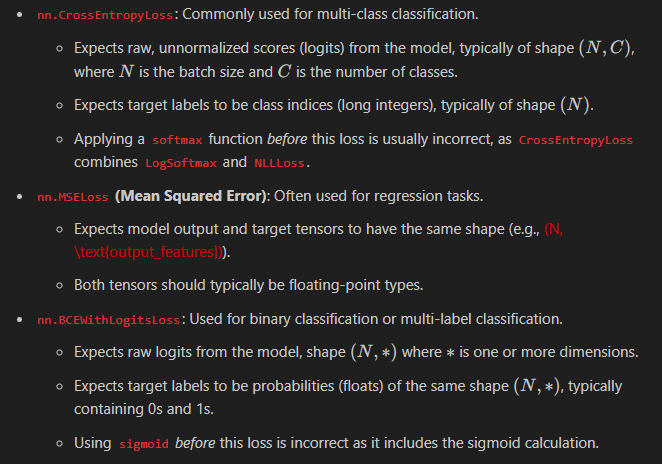

A mismatch here might result in:

* `RuntimeError` if shapes are fundamentally incompatible.
* Incorrect gradient calculations if data types are wrong (e.g., providing float targets to `CrossEntropyLoss`).
* A model that trains but learns poorly because the loss function is measuring the wrong thing (e.g., using `MSELoss` for classification indices).

### Inspecting Gradients for Issues (Vanishing/Exploding)

During backpropagation, gradients are calculated layer by layer using the chain rule. In deep networks, this involves multiplying many small numbers (derivatives) together.

* `Vanishing Gradients`: This occurs when gradients become extremely small as they propagate backward from the output layer to the initial layers. Consequently, the weights and biases of the initial layers are updated very slowly, or not at all. The network essentially stops learning meaningful features from the data in those early layers. This is particularly common in deep networks using activation functions like sigmoid or tanh, which have derivatives less than 1 in most regions.
* `Exploding Gradients`: This is the opposite problem, where gradients grow excessively large during backpropagation. Large gradients lead to significant updates in the model weights. This can cause the optimization process to become unstable, with the loss oscillating wildly or even becoming `NaN `(Not a Number), effectively halting training. Exploding gradients can occur due to poor weight initialization, high learning rates, or certain network structures, particularly in recurrent neural networks.

##### Detecting Gradient Issues in PyTorch

In [ ]:
# Inside your training loop, after loss.backward()

total_norm = 0
for p in model.parameters():
    if p.grad is not None:
        param_norm = p.grad.detach().data.norm(2) # Calculate L2 norm for this parameter's gradients
        total_norm += param_norm.item() ** 2      # Sum of squares
total_norm = total_norm ** 0.5                   # Square root of sum of squares

print(f"Total Gradient Norm: {total_norm}")

##### Inspecting Gradients per Layer

Sometimes, gradient issues might be localized to specific layers. We can inspect the gradients for individual parameters directly.

In [ ]:
# Inside your training loop, after loss.backward()

# Example: Inspect gradients for the first convolutional layer's weights
if hasattr(model, 'conv1') and model.conv1.weight.grad is not None:
    conv1_grad_mean = model.conv1.weight.grad.abs().mean().item()
    conv1_grad_max = model.conv1.weight.grad.abs().max().item()
    print(f"Layer conv1 - Mean Abs Gradient: {conv1_grad_mean:.6f}, Max Abs Gradient: {conv1_grad_max:.6f}")

# Example: Inspect gradients for a specific linear layer's bias
if hasattr(model, 'fc2') and model.fc2.bias.grad is not None:
    fc2_bias_grad_norm = model.fc2.bias.grad.norm(2).item()
    print(f"Layer fc2 (bias) - L2 Norm: {fc2_bias_grad_norm:.6f}")